Previously with linear regression (review - sales amount) we found out that our hypothsis about review will affect sales amount is incorrect as the correlation factors is around 0.05

Below process will use Random Forest Regression to analyse and predict sales amount with multiple attributes.


In [114]:
import os
from zipfile import ZipFile

# app.py
# call api 
# 1. According to kaggle website, api call require install package in pip -> pip install )
# 2. After install go to kaggle account page  https://www.kaggle.com/<username>/account to get api token
# 3. Place downloaded json file C:\Users\<Windows-username>\.kaggle\kaggle.json
os.system("kaggle datasets download -d olistbr/brazilian-ecommerce")
with ZipFile('brazilian-ecommerce.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()


os.system("kaggle datasets download -d olistbr/marketing-funnel-olist")
with ZipFile('marketing-funnel-olist.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
pd.set_option('display.max_columns', None) 

pd.set_option('display.max_rows', None) 
pd.set_option('max_colwidth',100)


customers=pd.read_csv('olist_customers_dataset.csv')
geolocation=pd.read_csv('olist_geolocation_dataset.csv')
order_items=pd.read_csv('olist_order_items_dataset.csv')
order_payments=pd.read_csv('olist_order_payments_dataset.csv')
order_reviews=pd.read_csv('olist_order_reviews_dataset.csv')
orders=pd.read_csv('olist_orders_dataset.csv')
products=pd.read_csv('olist_products_dataset.csv')
sellers=pd.read_csv('olist_sellers_dataset.csv')
translation=pd.read_csv('product_category_name_translation.csv')

market_qualified_leads = pd.read_csv('olist_marketing_qualified_leads_dataset.csv')
closed_deals = pd.read_csv('olist_closed_deals_dataset.csv')



In [116]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [117]:
def DataMerge_mql_closed_deals():
    mf = market_qualified_leads.merge(closed_deals, on='mql_id', how='left')
    #mf_sellers = mf.merge(sellers, on='seller_id', how='left')
    #mf_items = mf.merge(order_items, on='seller_id', how='left')
    return mf

def DataMerge_orderInfo():
    #orderid_amount=order_payments.groupby(['order_id']).agg({'payment_value':sum,'order_id':len})
    #orderid_amount.columns=['totalpayment_value','total_qty']
    #orderid_amount=orderid_amount.reset_index()
    orderid_amount=order_items.groupby(['order_id']).agg({'price':sum,'order_id':len})
    orderid_amount.columns=['totalprice_value','total_qty']
    orderid_amount=orderid_amount.reset_index()

    ops=orderid_amount.merge(order_items[['order_id', 'product_id', 'seller_id']],how='left',on='order_id')

    ops=ops.merge(products[['product_id','product_category_name','product_photos_qty']],how='left',on=['product_id'])

    ops=ops.merge(order_reviews[['review_score','order_id']],how='inner',on='order_id')

    for col in['order_delivered_customer_date','order_purchase_timestamp']:
        orders[col] = pd.to_datetime(orders[col])
    orders['delivery_days']=(orders['order_delivered_customer_date'].dt.date-orders['order_purchase_timestamp'].dt.date).dt.days

    ops=ops.merge(orders[['order_id', 'customer_id','order_purchase_timestamp','delivery_days']],how='inner',on='order_id')

    ops=ops.merge(customers[['customer_id','customer_city','customer_state']],how='inner',on='customer_id')

    #translate to English
    ops=pd.merge(ops,translation,on='product_category_name',how='left')

    ops['order_purchase_month_year'] = pd.to_datetime(ops['order_purchase_timestamp']).dt.to_period('M')
    ops.drop(columns=['order_purchase_timestamp'],inplace=True)
    ops=ops[ops.seller_id.notnull()]

    ###Aggregating on an orderid level
    ops['rc']=ops.groupby(['order_id']).cumcount()+1
    ops=ops[ops.rc==1]
    ops.drop(columns={'rc'},inplace=True)

    ##Ensuring Jan 2017-Sep 2018 is being considered
    ops=ops[(ops.order_purchase_month_year>='2017-01')&(ops.order_purchase_month_year<'2018-10')]

    ops.order_purchase_month_year.value_counts()
    ###Unique on Order_id level
    ops.shape,ops.order_id.nunique()
    return ops

    
def Plot_monthly_revenueGraph(ops):
    mr=pd.DataFrame(ops.order_purchase_month_year.value_counts()).reset_index()
    mr=ops.groupby(['order_purchase_month_year']).agg({'order_id':len,'totalprice_value':sum}).reset_index()
    mr.columns=['year_month','order_count','revenue_generated']
    mr.year_month=mr.year_month.astype(str)
    
    # create figure and axis objects with subplots()
    fig,ax = plt.subplots()
    plt.xticks(rotation=-45)
    # make a plot
    ax.plot(mr.year_month, mr.order_count, color="red", marker="o")
    # set x-axis label
    ax.set_xlabel("year_month",fontsize=14)
    # set y-axis label
    ax.set_ylabel("order_count",color="red",fontsize=14)
    ax.set_title('Monthly Performance Jan 2017-Sep 2018')
    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(mr.year_month, mr.revenue_generated,color="blue",marker="o")
    ax2.set_ylabel("revenue_generated",color="blue",fontsize=14)
    fig.set_size_inches(10,6)
    plt.show()

def Plot_top15_category(ops):
    top15_prodcat=pd.DataFrame(ops.product_category_name_english.value_counts().sort_values(ascending=False).head(15)).reset_index()
    top15_prodcat.columns=['product_category_name_english','order_count']
    fig=plt.gcf()
    fig.set_size_inches(20,10)
    graph=sns.barplot(y = 'product_category_name_english',x = 'order_count',data=top15_prodcat, orient = 'h')
    for p in graph.patches:
            graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                        ha='center', va='bottom',
                        color= 'black')
    plt.xticks(rotation=-45)
    
def ComputeFinalDataSet(ops,mf):
    ops1=ops.copy()
    final_data=pd.merge(ops1[ops1.seller_id.notnull()],mf[['seller_id','landing_page_id', 'origin','business_segment',
           'lead_type', 'lead_behaviour_profile','business_type']],how='left',on='seller_id')

    final_data['month_purchase']=final_data.order_purchase_month_year.dt.month

    final_data.order_id.nunique(),final_data.shape
    
    ##dropping high missing value column
    for col in final_data.columns:
        if ((final_data[col].isnull().sum())/(final_data.shape[0])>0.95):
            final_data.drop(columns=[col],inplace=True)

    final_data=final_data[final_data.product_category_name.notnull()]
    final_data.delivery_days.fillna(final_data.delivery_days.median(),inplace=True)
    final_data.columns

    column_list = ['product_category_name','customer_city','customer_state']#,'lead_type','lead_behaviour_profile','business_type','landing_page_id','origin']

    for column in column_list:
        encoder = preprocessing.LabelEncoder()
        encoder.fit(final_data[column])
        final_data[column] = encoder.transform(final_data[column])
    return final_data

Execute data merge

Merge useful data set for future use

In [118]:
mql_closed_deals = DataMerge_mql_closed_deals()

In [119]:
orderInfo = DataMerge_orderInfo()

Plot graphs for some insight

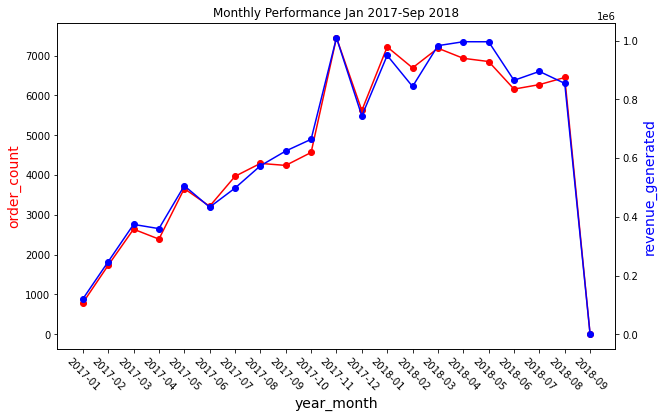

In [120]:
Plot_monthly_revenueGraph(orderInfo)

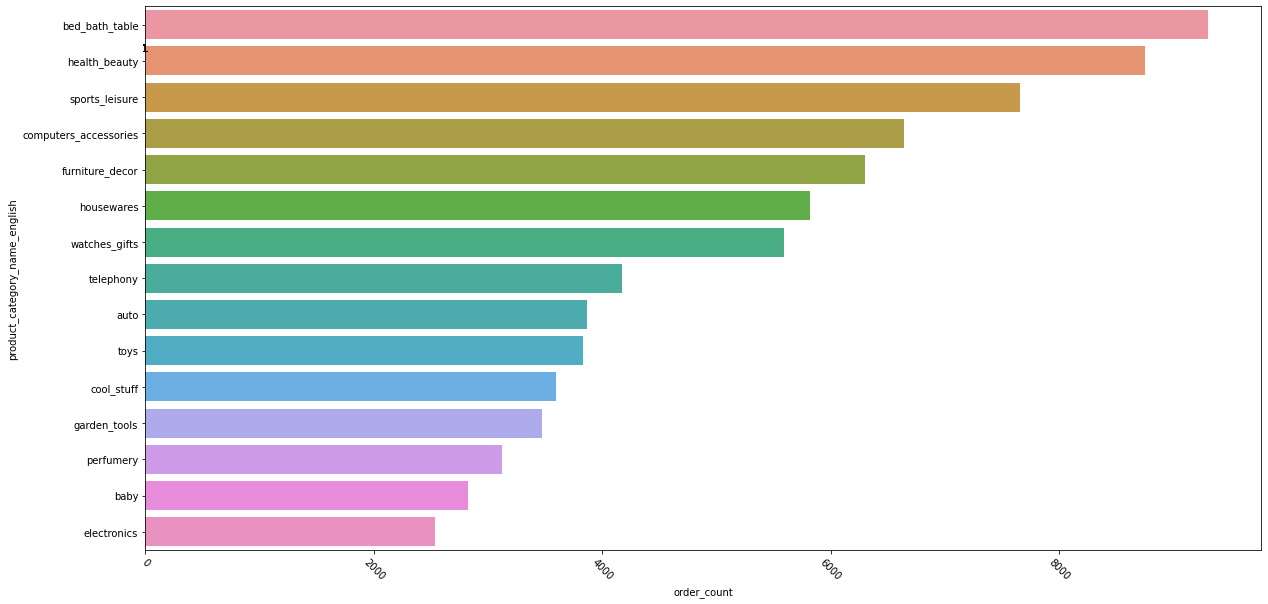

In [121]:
Plot_top15_category(orderInfo)

Compute final data set

In [122]:

final_data = ComputeFinalDataSet(orderInfo,mql_closed_deals)

In [123]:
#Splitting Data into Train and Test samples
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

def LinearRegression_process(final_data,predictor, response):
    Response = pd.DataFrame(final_data[response])  # Response
    Predictor = pd.DataFrame(final_data[predictor])        # Predictor

    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(Predictor, Response, test_size = 0.25)

    # Linear Regression using Train Data
    linreg = LinearRegression()         # create the linear regression object
    linreg.fit(X_train, y_train)        # train the linear regression model

    # Coefficients of the Linear Regression line
    print('Intercept of Regression \t: b = ', linreg.intercept_)
    print('Coefficients of Regression \t: a = ', linreg.coef_)
    print()

    # Predict Total values corresponding to HP
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test)

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
    print()

    # Plot the Predictions vs the True values
    f, axes = plt.subplots(1, 2, figsize=(24, 12))
    axes[0].scatter(y_train, y_train_pred, color = "blue")
    axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
    axes[0].set_xlabel("True values of the Response Variable (Train)")
    axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
    axes[1].scatter(y_test, y_test_pred, color = "green")
    axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
    axes[1].set_xlabel("True values of the Response Variable (Test)")
    axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
    plt.show()


def RandomForestRegression_process(final_data,predictor, response):

    X = final_data[predictor].values
    y = final_data[response].values
    split_test_size = 0.25

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state=8)

    print('Training Features Shape:', X_train.shape)
    print('Testing Features Shape:', X_test.shape)
    print('Training labels Shape:', y_train.shape)
    print('Testing labels Shape:', y_test.shape)
    
    rf_model_finaldata = RandomForestRegressor(n_estimators=100, min_samples_split=2, random_state = 20,n_jobs=-1)
    rf_model_finaldata.fit(X_train, np.ravel(y_train,order='C'))

    rf_predict_train = rf_model_finaldata.predict(X_train)
    rf_predict_test = rf_model_finaldata.predict(X_test)

    print("Mean Absolute error in predicting train data",mean_absolute_error(y_train,rf_predict_train))
    print("Mean Absolute error in predicting test data",mean_absolute_error(y_test,rf_predict_test))
    return rf_model_finaldata;
   
    
def heatmap_final_data():
    
    sns.heatmap(final_data.corr())

Training Features Shape: (72705, 5)
Testing Features Shape: (24235, 5)
Training labels Shape: (72705, 1)
Testing labels Shape: (24235, 1)
Mean Absolute error in predicting train data 0.11499921484671546
Mean Absolute error in predicting test data 0.25890931563103786


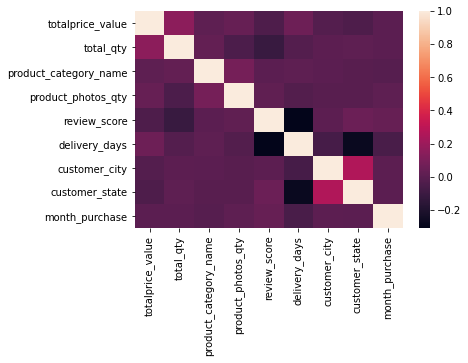

In [141]:

predictor = ['product_photos_qty','review_score','product_category_name',
             'delivery_days', 'customer_city']
response = ['total_qty']

rf_model_finaldata = RandomForestRegression_process(final_data,predictor,response)

heatmap_final_data()


In [142]:
final_data.head()

,order_id,totalprice_value,total_qty,product_id,seller_id,product_category_name,product_photos_qty,review_score,customer_id,delivery_days,customer_city,customer_state,product_category_name_english,order_purchase_month_year,month_purchase
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,26,4.0,5,3ce436f183e68e07877b285a838db11a,7.0,733,18,cool_stuff,2017-09,9
1,00018f77f2f0320c557190d7a144bdd3,239.90,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,63,2.0,4,f6dd3ec061db4e3987629fe6b26e5cce,16.0,3265,25,pet_shop,2017-04,4
2,000229ec398224ef6ca0657da4fc703e,199.00,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,54,2.0,5,6489ae5e4333f3693df5ad4372dab6d3,8.0,2645,10,furniture_decor,2018-01,1
3,00024acbcdf0a6daa1e931b038114c75,12.99,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,62,1.0,4,d4eb9395c8c0431ee92fce09860c5a06,6.0,327,25,perfumery,2018-08,8
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,40,1.0,5,58dbd0b2d70206bf40e62cd34e84d795,25.0,3999,25,garden_tools,2017-02,2


c:\users\xuchaoliang\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'customer_city'),
  Text(1, 0, 'delivery_days'),
  Text(2, 0, 'product_category_name'),
  Text(3, 0, 'review_score'),
  Text(4, 0, 'product_photos_qty')])

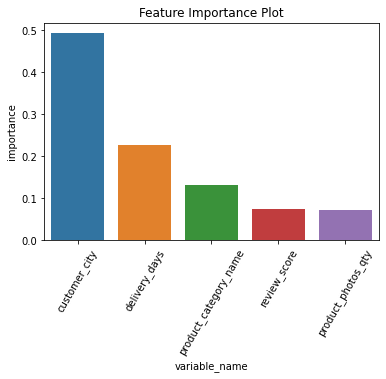

In [144]:

imp_features = pd.Series(rf_model_finaldata.feature_importances_,index=predictor).sort_values(ascending=False)
imp_features=pd.DataFrame(imp_features.reset_index())
imp_features.columns=['variable_name','importance']
sns.barplot('variable_name','importance',data=imp_features)
plt.title('Feature Importance Plot')
plt.xticks(rotation=60)


We will be interested in the top 3 factors